# Erlernen einer harmonischen Schwingung

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sin, pi
from random import *

### Im ersten Schritt generieren wir Daten, die physikalische Messwerte einer harmonischen Schwingung simulieren sollen. Die Messunschärfe wird dabei durch eine zufällige Fluktuation um die physikalisch korrekte (und zu erlernende) Sinusfunktion erzeugt. 

In [29]:
measurements = []
for i in range(0,5000):
    measurements.append(sin(0.1*i) + uniform(-0.1, 0.1))
measurements

[0.08205827815186978,
 0.09884032957430308,
 0.20019124571631064,
 0.3418024283152405,
 0.36450697958766254,
 0.5317547444235879,
 0.5236083179713185,
 0.6269378566473329,
 0.7617721717700567,
 0.7582952034345702,
 0.8147537215693106,
 0.7968190658870331,
 0.8902261032236622,
 0.9813409875221253,
 0.9045032721894963,
 0.9247073669643433,
 1.0744796727463508,
 1.0263917286797173,
 0.9193923246767856,
 0.9466883392000214,
 0.8882217811562316,
 0.9389453721033303,
 0.8088699197719611,
 0.8050650827498581,
 0.7343181931799911,
 0.503446822306488,
 0.43261161667541903,
 0.4223053952683258,
 0.3063587192154896,
 0.30861037249824247,
 0.08185222713297526,
 0.13027760270801086,
 -0.04522109126571722,
 -0.1697617778614296,
 -0.2959803789966315,
 -0.30784382351605044,
 -0.5339628384458608,
 -0.6113805363999322,
 -0.5753443188287434,
 -0.7632957997958857,
 -0.8529547885201817,
 -0.852556679402995,
 -0.9476166485611356,
 -0.8805561215344548,
 -0.9506981225843565,
 -0.9229579578641357,
 -0.92831966

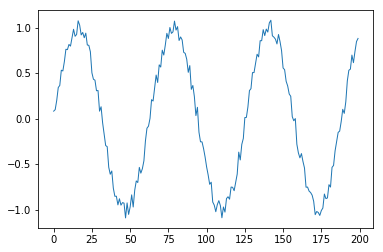

In [30]:
plt.plot(measurements[:200], label='measurements', linewidth=1)
plt.show()

In [31]:
X_train = measurements[:1000]
X_val = measurements[1000:]


print(X_val)

[-0.48293741870076357, -0.43012491671329134, -0.3209921072303122, -0.21408763799067954, -0.13702991228837105, 0.06374596493332982, -0.013693096831329202, 0.09296689964789878, 0.33692691887293647, 0.2885989552508469, 0.5360070636350167, 0.49053494972834155, 0.5327643465990708, 0.6964699532236454, 0.8082186158882605, 0.7709087480194403, 0.9736269142663483, 1.0096653095575978, 0.8669955738742824, 0.9216777654573395, 1.050975008702457, 1.0764511890732287, 0.9610880733454122, 1.0342570242115137, 0.9198336721205592, 0.8937889697287283, 0.8399692037171957, 0.8941457126433464, 0.7260211203657757, 0.6115301069268964, 0.5353960048591633, 0.6013546137562049, 0.3771283269684815, 0.28757619543856433, 0.34094891186143683, 0.26292582989852764, 0.020528196311363475, 0.003912950405308927, -0.11252352415750042, -0.15115965496492006, -0.3598178407683108, -0.4002042811954301, -0.4206790843324132, -0.5067299326455272, -0.6064867549390487, -0.7841975870392603, -0.8006316930026083, -0.8303378346224244, -0.97

### Unser Model wird auf einem rekurrenten neuronalen Netzwerk basieren. Details sind in den Folien zu finden. Hier ist es für uns erst einmal nur wichtig zu wissen, dass man versucht aus den letzten n Schritten (Messungen), den gegenwärtigen Wert zu bestimmen. Dazu müssen wir also die Messungen aufteilen in alle Kombinationen von n historischen (aufeinanderfolgenden) Werten (Features) und dem jeweils darauffolgenen Wert, der als Label dient. Diese Konstruktion stellt sicher, dass das Netzwerk nicht nur gegenwärtige Werte lernt, sondern auch versteht, wie diese historisch entstanden sind. Somit besteht die Möglichkeit typische Strukturen einer harmonischen Schwingung wie wiederkehrende Minima und Maxima besser zu erlernen.

In [32]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Im Folgenden wählen wir als Sequenzlänge 10. Der Wert erlaubt einen Trend zu erkennen, ohne dabei zu overfitten, was bei wesentlich größeren Werten der Fall sein kann. Außerdem benötigen die Schichten unseres Models (bzw. deren Implementierung in Keras) eine Reskalierung der Daten.

In [33]:
raw_seq = list(X_train)

n_steps = 10
X, y = split_sequence(raw_seq, n_steps)
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

### Unser Model besteht aus zwei aufeinanderfolgenden LSTM Zellen. Diese stellen modifizierte Versionen des Standard-RNN's dar. Insbesondere dienen sie als "Gedächtnis". Technisch bedeutet dies, dass sie durch eine komplexe interne Struktur die Probleme verschwindender bzw. explodierender Gradienten umgehen.

In [34]:
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=1)

Epoch 1/200
990/990 [==============================] - 2s 2ms/step - loss: 0.3386
Epoch 2/200
990/990 [==============================] - 0s 381us/step - loss: 0.1053
Epoch 3/200
990/990 [==============================] - 0s 376us/step - loss: 0.0381
Epoch 4/200
990/990 [==============================] - 0s 379us/step - loss: 0.0127
Epoch 5/200
990/990 [==============================] - 0s 382us/step - loss: 0.0085
Epoch 6/200
990/990 [==============================] - 0s 377us/step - loss: 0.0075
Epoch 7/200
990/990 [==============================] - 0s 378us/step - loss: 0.0068
Epoch 8/200
990/990 [==============================] - 0s 378us/step - loss: 0.0075
Epoch 9/200
990/990 [==============================] - 0s 376us/step - loss: 0.0072
Epoch 10/200
990/990 [==============================] - 0s 376us/step - loss: 0.0061
Epoch 11/200
990/990 [==============================] - 0s 379us/step - loss: 0.0059
Epoch 12/200
990/990 [==============================] - 0s 380us/step - loss

990/990 [==============================] - 0s 389us/step - loss: 0.0053
Epoch 98/200
990/990 [==============================] - 0s 384us/step - loss: 0.0053
Epoch 99/200
990/990 [==============================] - 0s 387us/step - loss: 0.0058
Epoch 100/200
990/990 [==============================] - 0s 386us/step - loss: 0.0054
Epoch 101/200
990/990 [==============================] - 0s 387us/step - loss: 0.0054
Epoch 102/200
990/990 [==============================] - 0s 387us/step - loss: 0.0061
Epoch 103/200
990/990 [==============================] - 0s 395us/step - loss: 0.0056
Epoch 104/200
990/990 [==============================] - 0s 385us/step - loss: 0.0051
Epoch 105/200
990/990 [==============================] - 0s 385us/step - loss: 0.0052
Epoch 106/200
990/990 [==============================] - 0s 385us/step - loss: 0.0055
Epoch 107/200
990/990 [==============================] - 0s 383us/step - loss: 0.0054
Epoch 108/200
990/990 [==============================] - 0s 385us/step

990/990 [==============================] - 0s 407us/step - loss: 0.0049
Epoch 193/200
990/990 [==============================] - 0s 403us/step - loss: 0.0049
Epoch 194/200
990/990 [==============================] - 0s 405us/step - loss: 0.0052
Epoch 195/200
990/990 [==============================] - 0s 409us/step - loss: 0.0049
Epoch 196/200
990/990 [==============================] - 0s 402us/step - loss: 0.0049
Epoch 197/200
990/990 [==============================] - 0s 406us/step - loss: 0.0050
Epoch 198/200
990/990 [==============================] - 0s 408us/step - loss: 0.0050
Epoch 199/200
990/990 [==============================] - 0s 407us/step - loss: 0.0049
Epoch 200/200
990/990 [==============================] - 0s 404us/step - loss: 0.0051


### Nun wollen wir unser Model auf der Validierungssatz testen.

In [35]:
X_v, y_v = split_sequence(list(X_val), n_steps)

In [36]:
X_validation = X_v.reshape((X_v.shape[0], X_v.shape[1], n_features))

In [37]:
yhat = model.predict(X_validation, verbose=0)
print(yhat)

[[ 0.42431247]
 [ 0.5388034 ]
 [ 0.61093855]
 ...
 [-0.18954577]
 [-0.26248506]
 [-0.32368374]]


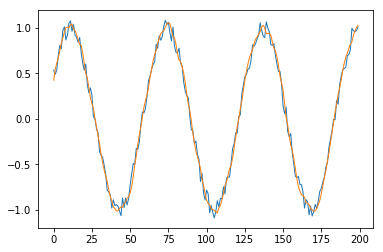

In [38]:
plt.plot(y_v[:200], label='true', linewidth=1)
plt.plot(yhat[:200], label='predicted', linewidth=1)
plt.show()

### Man erkennt, dass der Algorithmus die Periodizität der Schwingung gelernt hat. Außerdem ist festzustellen, dass die gelernte Kurve glatter ist, als die Messdaten. Dies bedeutet also, dass erkannt wird, dass es sich bei der Fluktuationen um eine physikalisch nicht-relevante Messungenauigkeit handelt. 

In [39]:
yhat_train = model.predict(X, verbose=0)
print(yhat_train)

[[ 0.85663986]
 [ 0.9023616 ]
 [ 0.91206753]
 [ 0.9379748 ]
 [ 0.97786635]
 [ 0.9770231 ]
 [ 0.9828438 ]
 [ 0.99752325]
 [ 0.99314904]
 [ 0.95518434]
 [ 0.92741144]
 [ 0.88365376]
 [ 0.8592977 ]
 [ 0.7994425 ]
 [ 0.7527297 ]
 [ 0.6891682 ]
 [ 0.5528043 ]
 [ 0.42021784]
 [ 0.3174767 ]
 [ 0.21233997]
 [ 0.14629447]
 [ 0.02877899]
 [-0.03531805]
 [-0.12530082]
 [-0.22460574]
 [-0.33408108]
 [-0.42687166]
 [-0.5576228 ]
 [-0.6724272 ]
 [-0.7395248 ]
 [-0.8142535 ]
 [-0.88979614]
 [-0.9307246 ]
 [-0.97694045]
 [-0.99425465]
 [-1.0021949 ]
 [-0.9807228 ]
 [-0.9577316 ]
 [-0.97030926]
 [-0.9424808 ]
 [-0.95434165]
 [-0.9514651 ]
 [-0.8952999 ]
 [-0.87666005]
 [-0.8069309 ]
 [-0.70791566]
 [-0.6257416 ]
 [-0.51187664]
 [-0.4553967 ]
 [-0.38426942]
 [-0.33307424]
 [-0.23215133]
 [-0.09789377]
 [-0.00533312]
 [ 0.09964844]
 [ 0.24049875]
 [ 0.33863983]
 [ 0.44850734]
 [ 0.5486144 ]
 [ 0.58409774]
 [ 0.647267  ]
 [ 0.69601583]
 [ 0.78079593]
 [ 0.8230536 ]
 [ 0.8659109 ]
 [ 0.9296073 ]
 [ 0.95581

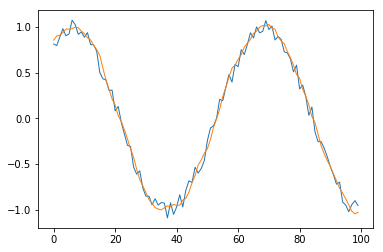

In [40]:
plt.plot(y[:100], label='true', linewidth=1)
plt.plot(yhat_train[:100], label='predicted', linewidth=1)
plt.show()